
## Skin disease detection - CNN pre-trained Model: Densenet121


`Project Type: Deep Learning Project (Skin Disease Classification)`



### Loading Important Library

In [1]:
import itertools
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization ,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



### Directory Paths
- `train_data_dir`: Path to the directory containing training data.
- `test_data_dir`: Path to the directory containing test data.
- `val_data_dir`: Path to the directory containing validation data.

### Parameters
- `epochs`: This parameter determines the number of times the entire dataset will be passed forward and backward through the neural network during the training process. 
  Each pass constitutes one epoch.

- `batch_Train`: Specifies the number of training examples utilized in one iteration of training. It affects the speed and stability of training, as well as memory consumption.

- `batch_Test`: Similar to `batch_Train`, but specifies the number of test examples utilized in one iteration during evaluation. It affects the efficiency of model evaluation.

- `image_size`:  Defines the dimensions (height and width) to which input images will be resized before being fed into the model. 
  Ensuring uniform image size is often necessary for compatibility with neural network architectures.

- `num_classes`: the number of distinct classes or categories present in the classification task.

- `learning_rate`: Determines the step size at which the model parameters are updated during training. It influences the convergence and stability of the training process.


In [2]:
train_data_dir = "./train"
test_data_dir = "./test"
val_data_dir = "./val"

# Parameters
epochs = 100
batch_Train = 100
batch_Test = 100
image_size = (224, 224)
num_classes = 4
learning_rate = 0.001


### Data Augmentation Parameters
- `datagen_args`: Parameters for data augmentation including rescaling, rotation, shifting, flipping, etc.
### Data Augmentation Generators
- `train_datagen`, `val_datagen`: Generators for augmenting training and validation data respectively.
- `test_datagen`: Generator for rescaling test data.
### Image Preprocessing Functions
- `apply_dull_razor`: Applies a dull razor effect to an image.
- `preprocess_image`: Preprocesses an image by applying dull razor effect.




In [3]:

# Define data augmentation parameters in one dictionary
datagen_args = dict(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    featurewise_std_normalization=True
)

# Data augmentation for training and validation data
train_datagen = ImageDataGenerator(**datagen_args)
val_datagen = ImageDataGenerator(**datagen_args)

# Only rescaling for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

def apply_dull_razor(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    bhg = cv2.GaussianBlur(blackhat, (5, 5), cv2.BORDER_DEFAULT)
    _, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(image, mask, 1, cv2.INPAINT_TELEA)
    return inpainted_image

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV processing
    img = apply_dull_razor(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert back to RGB
    return img

# Assuming these variables are defined: train_data_dir, image_size, batch_Train, test_data_dir, batch_Test, val_data_dir
sample_dir = train_data_dir 
sample_image_files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if os.path.isfile(os.path.join(sample_dir, f))][:3]

for img_path in sample_image_files:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    print("Original Image:")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Apply augmentation to the image and display
    i = 0
    for batch in train_datagen.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(array_to_img(batch[0]))
        plt.axis('off')
        plt.show()
        i += 1
        if i % 3 == 0:  # Display three augmented versions
            break
        
# Flow from directory for training, testing, and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_Train,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_Test,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=image_size,
    batch_size=batch_Train,
    class_mode='categorical'
)


c:\Users\Admin\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\preprocessing\image.py:1462: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 6139 images belonging to 4 classes.
Found 565 images belonging to 4 classes.
Found 1056 images belonging to 4 classes.


c:\Users\Admin\anaconda3\envs\tensorflowgpu\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


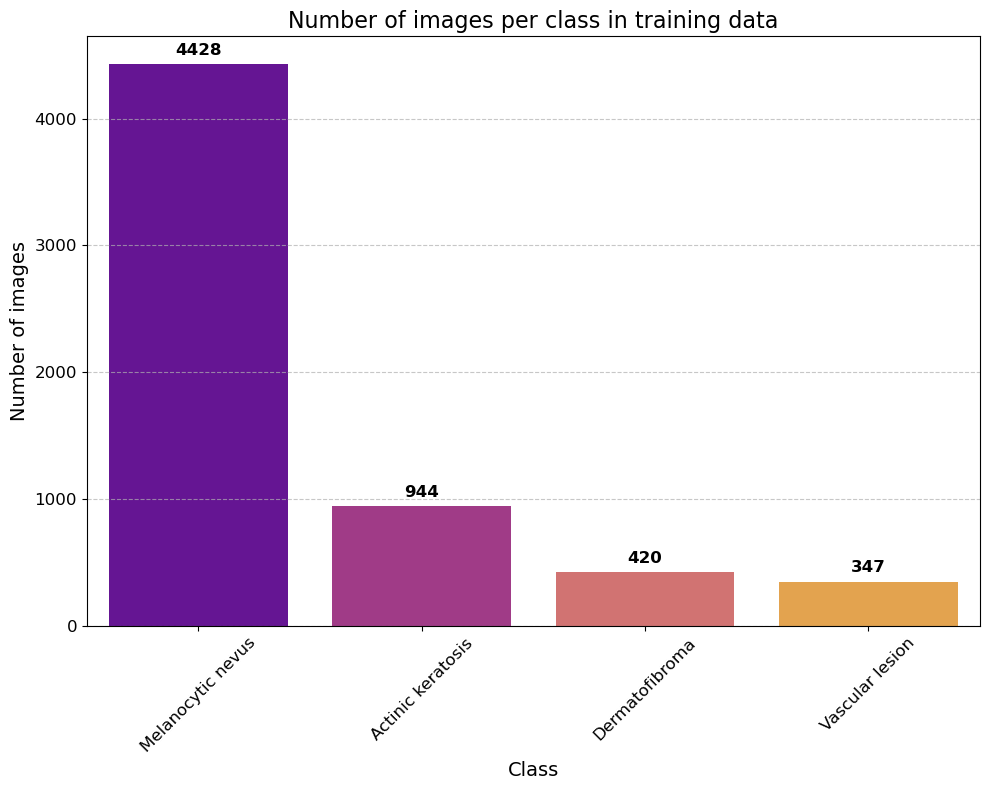

In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing the training data
train_data_dir = "./train"

# Get the class names from the directory structure
class_names = [d.name for d in os.scandir(train_data_dir) if d.is_dir()]

# Count the number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(train_data_dir, class_name))) for class_name in class_names}

# Sort the classes for better readability
class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution
plt.figure(figsize=(10, 8))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="plasma")

# Adding labels on top of the bars
for index, value in enumerate(class_counts.values()):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of images', fontsize=14)
plt.title('Number of images per class in training data', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

 ### `Model Architecture of DenseNet121`



In [ ]:

# Load the DenseNet121 model with pre-trained ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inputs = base_model.output

x = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# Removed the last max pooling layer to avoid dimensionality reduction beyond 1x1
x = Dropout(0.2)(x)

# Flatten the output of the convolutional layers
x = Flatten()(x)

# Fully-connected layers with BatchNormalization
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
# import visualkeras
# visualkeras.layered_view(model, to_file='RES.png')

In [6]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, dpi=500)

### Freeze all layers in the base model initially, then unfreeze the top 30 layers for fine-tuning. 
### Compile the model with Adam optimizer and categorical crossentropy loss, using accuracy as the evaluation metric.

In [7]:

# Initially, freeze all layers  
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
callback_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=2,patience=10,min_delta = 0.001),
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs,callbacks=[callback_stop])

### Define a function to plot training and validation loss and accuracy over epochs.

In [ ]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    # Determine the best epochs
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Set the plot's size and style
    plt.figure(figsize=(15, 6))
    plt.style.use('fivethirtyeight')

    # Create epoch array
    epochs = list(range(1, len(tr_acc) + 1))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best Epoch: {index_loss + 1}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='red', label=f'Best Epoch: {index_acc + 1}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

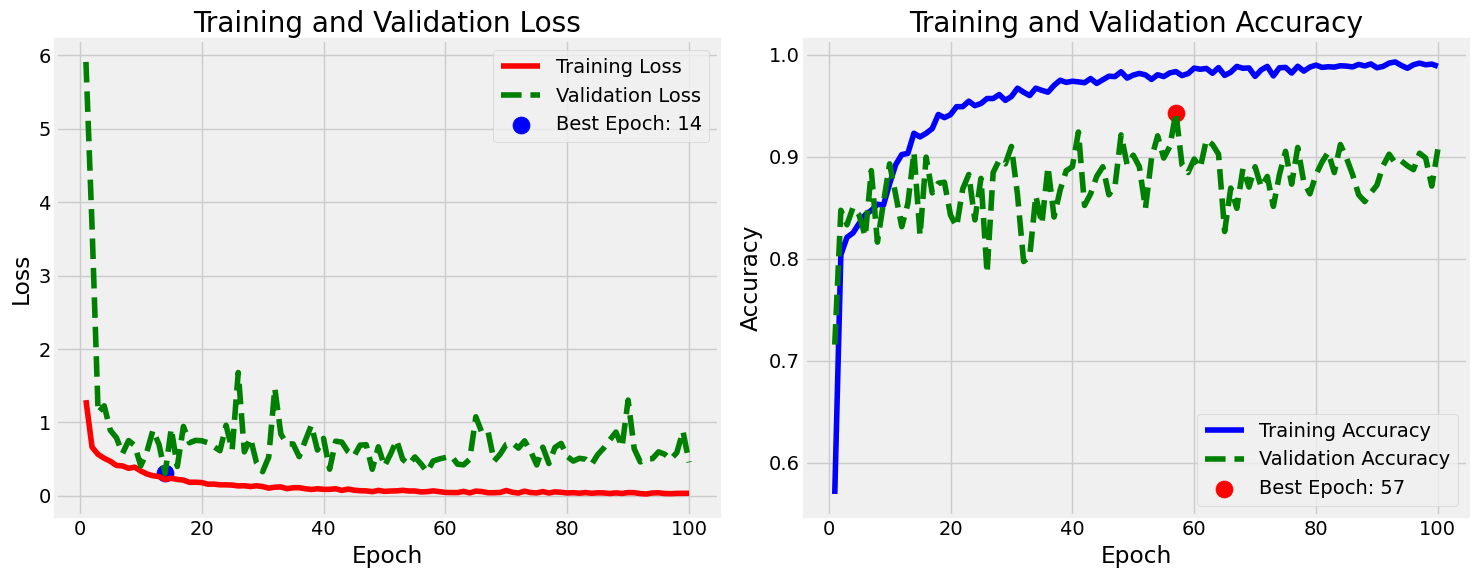

In [ ]:
plot_training(history)

### Define a test data generator with image rescaling and flow from a directory for image classification tasks.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    r'D:\Senior 4\Graduat_Project\semester 2\Project\isic original\test',
    target_size=(224, 224),
    batch_size=batch_Test,
    class_mode='categorical',
    shuffle=False
)




Found 565 images belonging to 4 classes.


In [ ]:
class_labels = ["Actinic keratosis", "Dermatofibroma", "Melanocytic nevus", "Vascular lesion"]

## evaluation and analysis Results

6/6 [==============================] - 32s 6s/step - loss: 0.1391 - accuracy: 0.9646
Test Accuracy: 0.9646017551422119
Test Loss: 0.1391231119632721
6/6 [==============================] - 7s 686ms/step


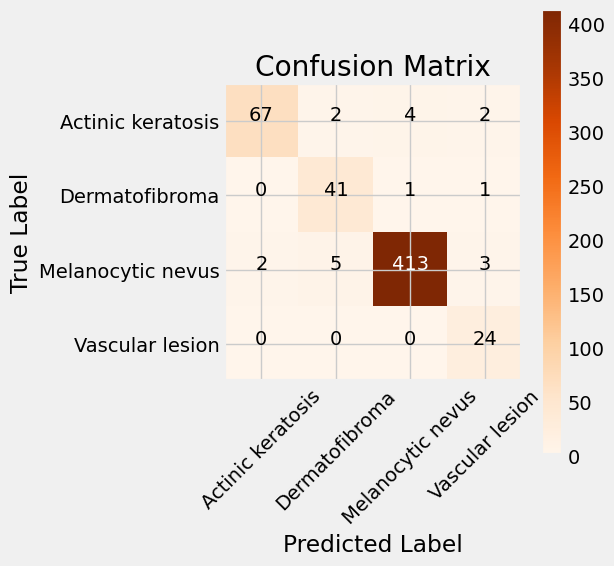

6/6 [==============================] - 4s 680ms/step
Classification Report:
                    precision    recall  f1-score   support

Actinic keratosis       0.97      0.89      0.93        75
   Dermatofibroma       0.85      0.95      0.90        43
Melanocytic nevus       0.99      0.98      0.98       423
  Vascular lesion       0.80      1.00      0.89        24

         accuracy                           0.96       565
        macro avg       0.90      0.96      0.93       565
     weighted avg       0.97      0.96      0.97       565



In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

# Predict on the test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
            horizontalalignment='center',
            color='white' if conf_matrix[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Generate and print classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

### Extract features from a model using a data generator.

In [ ]:
def extract_features(model, data_generator):
    features = []
    labels = []
    for inputs_batch, labels_batch in data_generator:
        features_batch = model.predict(inputs_batch)
        features.extend(features_batch)
        labels.extend(np.argmax(labels_batch, axis=1))  # Convert from one-hot to class labels
        if len(features) >= len(data_generator):
            break
    return np.array(features), np.array(labels)


### Use extracted features to train a Support Vector Machine (SVM) classifier.

In [ ]:
test_features, test_labels = extract_features(model, test_generator)

svc_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='poly', degree=3))
])
svc_model.fit(test_features, test_labels)

4/4 [==============================] - 8s 755ms/step


Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(kernel='poly'))])

In [ ]:
# Optionally, you can save the trained SVC model
from joblib import dump
dump(svc_model, '3.joblib')

['3.joblib']

### Load a pre-trained Support Vector Classifier (SVC) model, predict using extracted features, and evaluate performance.

In [ ]:
from joblib import load
import numpy as np

# Load the pre-trained SVC model from a joblib file
svc_model = load('3.joblib')

# Predict using the trained SVC
predictions_svc = svc_model.predict(test_features)

# Evaluate the predictions
accuracy_svc = np.mean(predictions_svc == test_labels)
misclassification_rate = 1 - accuracy_svc  # This is the proportion of incorrect predictions

print("Test Accuracy (SVC):", accuracy_svc)
print("Misclassification Rate (Loss):", misclassification_rate)


Test Accuracy (SVC): 0.99
Misclassification Rate (Loss): 0.010000000000000009


In [ ]:
# Save the entire model (DenseNet121 + SVC) for later use
model.save("3.h5")


### loading File.h5 and Make Prediction

1/1 [==============================] - 3s 3s/step
Predicted Class: Vascular lesion
Probability: 0.99999976


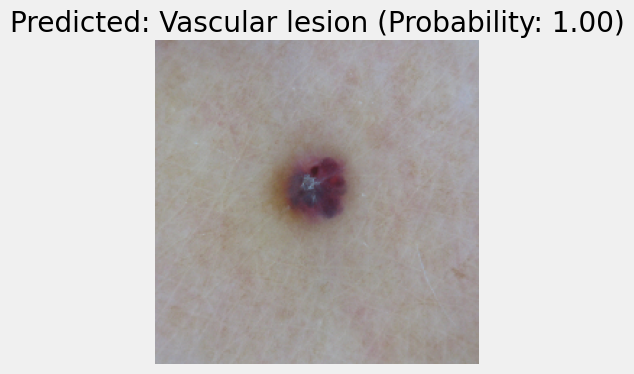

In [ ]:
from tensorflow.keras.preprocessing import image


model_loaded = tf.keras.models.load_model('3.h5')

# Define a function to predict the class and probabilities of an image
def predict_image(model, img_path, class_names):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale pixel values to [0, 1]

    # Make prediction
    predictions = model.predict(img_array)

    # Get the predicted class and its probability
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    probability = predictions[0, predicted_class_index]

    return img, predicted_class, probability

# Define the class names (you may need to adjust this based on your dataset)
class_names = ['Actinic keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Vascular lesion']

# Path to the image you want to predict
img_path = r'D:\Senior 4\Graduat_Project\semester 2\Project\isic original\test\Vascular lesion\ISIC_0070899.jpg'
# Make prediction
img, predicted_class, probability = predict_image(model_loaded, img_path, class_names)

# Display the predicted class and probabilities
print("Predicted Class:", predicted_class)
print("Probability:", probability)

# Show the image with the prediction
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class} (Probability: {probability:.2f})')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()